# Load images

In [43]:
# source:
# https://github.com/scikit-image/skimage-tutorials/blob/main/lectures/solutions/adv3_panorama-stitching-solution.ipynb

# import packages
import numpy as np
from skimage import io, color, transform, feature, measure
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [31]:
# load images
image_dir = './images'
files = sorted(os.listdir(image_dir))
images = []
for file_name in tqdm(files):
    image = io.imread(f"{image_dir}/{file_name}")
    gray_image = (color.rgb2gray(image)*255).astype(np.uint8)
    image_resized = transform.resize(
        gray_image, 
        (gray_image.shape[0] // 3, gray_image.shape[1] // 3),
        anti_aliasing=True
        )
    images.append(image_resized)

  0%|          | 0/30 [00:00<?, ?it/s]

# Find match points

In [34]:
# Initialize ORB
# 800 keypoints is large enough for robust results, 
# but low enough to run within a few seconds. 
orb = feature.ORB(n_keypoints=800, fast_threshold=0.05)

In [38]:
# find keypoints
keypoints_list = []
descriptor_list = []
for image in tqdm(images):
    # detect keypoints in img
    orb.detect_and_extract(image)
    keypoints_list.append(orb.keypoints)
    descriptor_list.append(orb.descriptors)


  0%|          | 0/30 [00:00<?, ?it/s]

In [39]:
# get matching descriptors
matches_list = []
for n in tqdm(list(range(0,len(descriptor_list)))):
    if n+1 != len(descriptor_list):
        descriptor_1 = descriptor_list[n]
        descriptor_2 = descriptor_list[n+1]
        matches_list.append(
            feature.match_descriptors(
                descriptor_1, 
                descriptor_2, 
                cross_check=True
                )
            )

  0%|          | 0/30 [00:00<?, ?it/s]

(0.0, 3072.0, 704.0, 0.0)

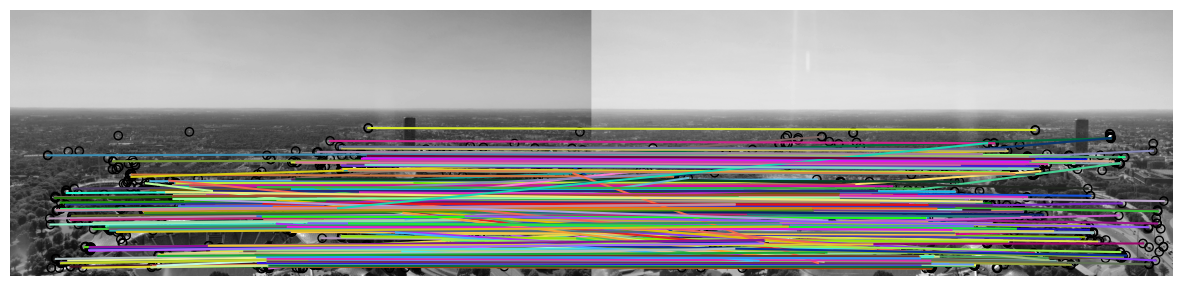

In [40]:
# plot matches
i = 3
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
feature.plot_matches(
    ax, 
    images[i], 
    images[i+1], 
    keypoints_list[i], 
    keypoints_list[i+1], 
    matches_list[i])
ax.axis('off')

# Transform estimation

In [66]:
model_robust_list = []
inliers_list = []
for n in tqdm(list(range(0,len(keypoints_list)))):
    if n+1 != len(descriptor_list):
        # Select keypoints from 
        #   * source (image to be registered): image n
        #   * target (reference image): image n+1
        src = keypoints_list[n][matches_list[n][:, 0]][:, ::-1]
        dst = keypoints_list[n+1][matches_list[n][:, 0]][:, ::-1]

        model_robust, inliers = measure.ransac(
            (src, dst), 
            transform.ProjectiveTransform,
            min_samples=5, 
            residual_threshold=1, 
            max_trials=300
        )
        model_robust_list.append(model_robust)
        inliers_list.append(inliers)



  0%|          | 0/30 [00:00<?, ?it/s]

(0.0, 3072.0, 704.0, 0.0)

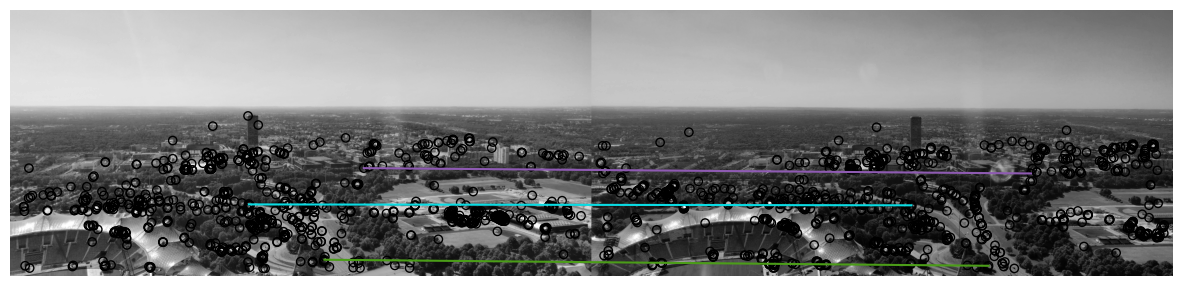

In [69]:
# plot matches
i = 1
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
feature.plot_matches(
    ax, 
    images[i], 
    images[i+1], 
    keypoints_list[i], 
    keypoints_list[i+1], 
    matches_list[i][inliers_list[i]])
ax.axis('off')

# Warping